In [5]:
import xarray as xr
import pandas as pd 
import regionmask
def convert_to_monthly_timeseries(df):
    # Drop the 'Unnamed: 0' column if it exists
    print(df.columns)
    if 'Unnamed: 0' in df.columns:
        print('Hello')
        df = df.drop(columns=['Unnamed: 0'])

    # Create monthly datetime index starting from January 1850
    # Use mid-month convention (15th), alternating 00:00 and 12:00 like shown
    start_date = '1850-01-15'
    dates = pd.date_range(start=start_date, periods=len(df), freq='MS')
    
    # Alternate time stamps between 00:00 and 12:00 like target format
    times = [
        date + pd.Timedelta(hours=12) if i % 2 else date
        for i, date in enumerate(dates)
    ]
    
    # Replace time column
    df['time'] = times

    # Move time to first column
    cols = ['time'] + [col for col in df.columns if col != 'time']
    df = df[cols]

    return df

def reorder_columns(df):
    # Ensure required columns exist
    if 'time' not in df.columns or 'GLOBAL' not in df.columns:
        raise ValueError("DataFrame must contain 'time' and 'GLOBAL' columns")

    if 'Unnamed: 0' in df.columns:
        print('Hello')
        df = df.drop(columns=['Unnamed: 0'])

    # Extract all columns except time and GLOBAL
    middle_cols = [col for col in df.columns if col not in ['time', 'GLOBAL']]
    
    # Sort the region columns alphabetically
    middle_cols_sorted = sorted(middle_cols)

    # Reconstruct column order
    new_column_order = ['time'] + middle_cols_sorted + ['GLOBAL']

    # Reorder dataframe
    return df[new_column_order]

import pandas as pd

import pandas as pd

def prepend_equivalent(sim: pd.DataFrame, equivalent: pd.DataFrame, start_year: int = 2041) -> pd.DataFrame:
    """
    Prepend monthly values from `equivalent` to `sim` for all months before `start_year`,
    keeping proper chronological order.
    """
    sim = sim.copy()
    equivalent = equivalent.copy()

    # Extract year-month as integer for sorting (YYYYMM)
    equivalent['year_month'] = equivalent['time'].str[:7].str.replace('-', '').astype(int)
    sim['year_month'] = sim['time'].str[:7].str.replace('-', '').astype(int)

    # Select only months before start_year from equivalent
    equivalent_early = equivalent[equivalent['year_month'] < start_year * 100]

    # Combine: first equivalent early months, then sim
    combined = pd.concat([equivalent_early, sim], ignore_index=True)

    # Sort by year_month to preserve chronological monthly order
    combined = combined.sort_values('year_month').reset_index(drop=True)

    # Drop helper column
    combined = combined.drop(columns='year_month')

    return combined



In [17]:
import matplotlib.pyplot as plt 
import numpy as np 
flat_10_path = f'/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_flat10-r1i1p1f1_tas_ipcc-regions_latweight.csv'
flat_10_cdr_path = f'/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_flat10cdr-r1i1p1f1_tas_ipcc-regions_latweight.csv'
flat_10_zec_path = f'/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_flat10zec-r1i1p1f1_tas_ipcc-regions_latweight.csv'
other_Scenario = '/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_ssp126-r9i1p1f1_tas_ipcc-regions_latweight.csv'
flat_10_cdr_incspinoff_path = f'/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_flat10cdrincspinoff-r1i1p1f1_tas_ipcc-regions_latweight.csv'
flat_10_zec_incspinoff_path = f'/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_flat10zecincspinoff-r1i1p1f1_tas_ipcc-regions_latweight.csv'

flat_10 = pd.read_csv(flat_10_path)
flat_10_cdr = pd.read_csv(flat_10_cdr_path)
flat_10_zec = pd.read_csv(flat_10_zec_path)

#print(flat_10)
#print(flat_10_cdr)
#print(flat_10_zec)

# --- parameters ---
YEARS_SHIFT = 100
MONTHS_PER_YEAR = 12
N_SHIFT = YEARS_SHIFT * MONTHS_PER_YEAR

def shift_and_prepend(flat10, scenario_df):
    """
    Prepend first 100 years of flat10, then shift scenario forward by 100 years.
    """
    # Ensure time is datetime
    flat10 = flat10.copy()
    scenario_df = scenario_df.copy()
    flat10["time"] = pd.to_datetime(flat10["time"])
    scenario_df["time"] = pd.to_datetime(scenario_df["time"])

    # --- take first 100 years of flat10 ---
    flat10_prefix = flat10.iloc[:N_SHIFT].copy()

    # --- shift scenario forward by 100 years ---
    scenario_df["time"] = scenario_df["time"] + pd.DateOffset(years=YEARS_SHIFT)

    # --- concatenate ---
    combined = pd.concat([flat10_prefix, scenario_df], ignore_index=True)

    combined = combined.iloc[:-1]

    return combined

def plot_global_and_random_regions_annual(
    df,
    n_regions=10,
    seed=None,
    figsize=(12, 6)
):
    """
    Plot annual-mean GLOBAL temperature and n random regional time series.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain 'time', 'GLOBAL', and regional columns
    n_regions : int
        Number of random regional columns to plot
    seed : int or None
        Random seed for reproducibility
    figsize : tuple
        Figure size
    """
    if seed is not None:
        np.random.seed(seed)

    # --- copy & ensure datetime ---
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # --- annual mean ---
    df_annual = (
        df
        .set_index("time")
        .resample("YS")      # Year Start
        .mean()
        .reset_index()
    )

    # Identify regional columns
    regional_cols = [
        c for c in df_annual.columns
        if c not in ["time", "GLOBAL"]
    ]

    if n_regions > len(regional_cols):
        raise ValueError("n_regions exceeds number of available regions")

    chosen_regions = np.random.choice(
        regional_cols, size=n_regions, replace=False
    )

    # --- plotting ---
    plt.figure(figsize=figsize)

    # GLOBAL
    plt.plot(
        df_annual["time"],
        df_annual["GLOBAL"],
        color="black",
        linewidth=2.5,
        label="GLOBAL"
    )

    # Regional series
    for region in chosen_regions:
        plt.plot(
            df_annual["time"],
            df_annual[region],
            linewidth=1.2,
            alpha=0.7,
            label=region
        )

    plt.xlabel("Year")
    plt.ylabel("Temperature (K)")
    plt.title("Annual mean GLOBAL and regional temperatures")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- apply to both scenarios ---
flat10cdr_shifted = shift_and_prepend(flat_10, flat_10_cdr)
flat10zec_shifted = shift_and_prepend(flat_10, flat_10_zec)

flat10zec_shifted = reorder_columns(flat10zec_shifted)
flat10cdr_shifted = reorder_columns(flat10cdr_shifted)
#plot_global_and_random_regions_annual(flat10cdr_shifted, seed=1)
#plot_global_and_random_regions_annual(flat10zec_shifted, seed=7)

flat10cdr_shifted.to_csv(flat_10_cdr_incspinoff_path, index = False)
flat10zec_shifted.to_csv(flat_10_zec_incspinoff_path, index = False)

print(pd.read_csv(flat_10_cdr_incspinoff_path))



                     time        ARO        ARP        ARS        BOB  \
0     1850-02-01 00:00:00  242.08507  286.12302  297.13907  298.80680   
1     1850-03-01 12:00:00  246.43114  287.95395  297.12490  298.69025   
2     1850-04-01 00:00:00  243.01668  292.31778  297.84073  299.44650   
3     1850-05-01 12:00:00  253.85725  296.26865  298.70648  300.46014   
4     1850-06-01 00:00:00  263.98163  300.28833  299.83320  301.47018   
...                   ...        ...        ...        ...        ...   
3834  2169-08-01 00:00:00  273.74762  304.22028  300.53452  301.88455   
3835  2169-09-01 12:00:00  272.53793  304.13776  299.86990  301.83722   
3836  2169-10-01 00:00:00  264.95300  300.94110  300.03006  301.88870   
3837  2169-11-01 12:00:00  256.83722  298.02432  300.50067  301.75638   
3838  2169-12-01 00:00:00  254.55807  292.09730  299.75780  300.74628   

            CAF        CAR        CAU        CNA        EAN  ...        SWS  \
0     296.83215  298.19464  301.76956  274.1

In [2]:
exp = 'flat10'
flat_10_path = f'/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-CM2/access-cm2_{exp}-r1i1p1f1_tas_ipcc-regions_latweight.csv'
flat_10_path_save = f'/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-CM2/access-cm2_{exp}-r1i1p1f1_tas_ipcc-regions_latweight.csv'
df_flat10 = pd.read_csv(flat_10_path)
df_simulation = pd.read_csv('/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-CM2/access-cm2_ssp585-r1i1p1f1_tas_ipcc-regions_latweight.csv')

regions = regionmask.defined_regions.ar6.all
rename_dict = dict(zip(regions.names, regions.abbrevs))
rename_dict['global']='GLOBAL'
df_flat10 = df_flat10.rename(columns=rename_dict)
df_flat10 = convert_to_monthly_timeseries(df_flat10)
df_flat10 = reorder_columns(df_flat10)

df_flat10.to_csv(flat_10_path_save, index=False)
print(df_flat10)
#print(df_simulation)
print(pd.read_csv(flat_10_path_save))

Index(['time', 'ARO', 'ARP', 'ARS', 'BOB', 'CAF', 'CAR', 'CAU', 'CNA', 'EAN',
       'EAO', 'EAS', 'EAU', 'ECA', 'EEU', 'EIO', 'ENA', 'EPO', 'ESAF', 'ESB',
       'GIC', 'MDG', 'MED', 'NAO', 'NAU', 'NCA', 'NEAF', 'NEN', 'NES', 'NEU',
       'NPO', 'NSA', 'NWN', 'NWS', 'NZ', 'RAR', 'RFE', 'SAH', 'SAM', 'SAO',
       'SAS', 'SAU', 'SCA', 'SEA', 'SEAF', 'SES', 'SIO', 'SOO', 'SPO', 'SSA',
       'SWS', 'TIB', 'WAF', 'WAN', 'WCA', 'WCE', 'WNA', 'WSAF', 'WSB',
       'GLOBAL'],
      dtype='object')
                    time        ARO        ARP        ARS        BOB  \
0    1850-02-01 00:00:00  242.08507  286.12302  297.13907  298.80680   
1    1850-03-01 12:00:00  246.43114  287.95395  297.12490  298.69025   
2    1850-04-01 00:00:00  243.01668  292.31778  297.84073  299.44650   
3    1850-05-01 12:00:00  253.85725  296.26865  298.70648  300.46014   
4    1850-06-01 00:00:00  263.98163  300.28833  299.83320  301.47018   
...                  ...        ...        ...        ...        ... 

In [18]:
sim = '/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/tas_Amon_ACCESS-ESM1-5_ssp534-over_r1i1p1f2_aggregates.csv'
equivalent_path = '/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_ssp585-r1i1p1f1_tas_ipcc-regions_latweight.csv'
sim_new_path = '/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_ssp534-over-r1i1p1f1_tas_ipcc-regions_latweight.csv'
simu = reorder_columns(pd.read_csv(sim))
equivalent = pd.read_csv(equivalent_path)

save = prepend_equivalent(simu,equivalent)
print(save.columns)
save.to_csv(sim_new_path, index=False)
print(pd.read_csv(equivalent_path).columns)

Hello
Index(['time', 'GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR',
       'NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE', 'EEU',
       'MED', 'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG',
       'RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS',
       'SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ', 'EAN', 'WAN', 'ARO', 'NPO',
       'EPO', 'SPO', 'NAO', 'EAO', 'SAO', 'ARS', 'BOB', 'EIO', 'SIO', 'SOO',
       'GLOBAL'],
      dtype='object')
Index(['time', 'GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR',
       'NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE', 'EEU',
       'MED', 'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG',
       'RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS',
       'SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ', 'EAN', 'WAN', 'ARO', 'NPO',
       'EPO', 'SPO', 'NAO', 'EAO', 'SAO', 'ARS', 'BOB', 'EIO', 'SIO', 'SOO',
       'GLOBAL'],
      dtype='objec

True


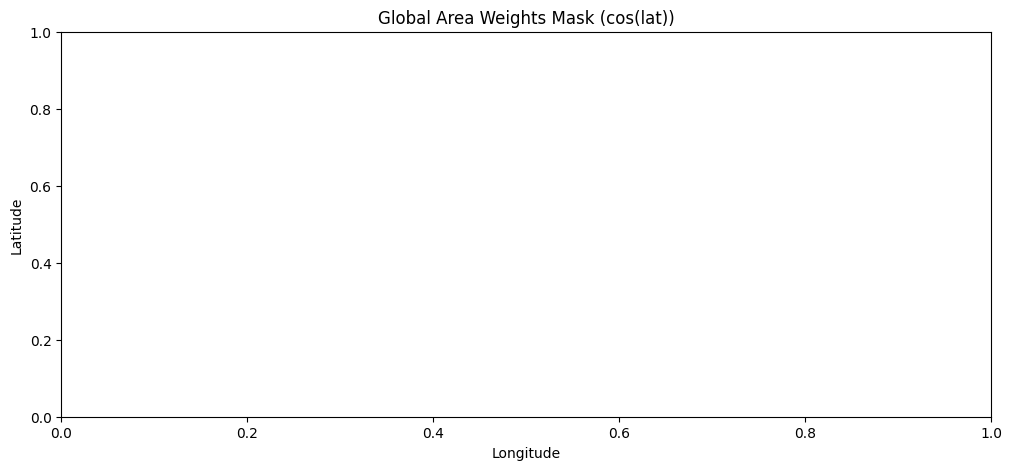

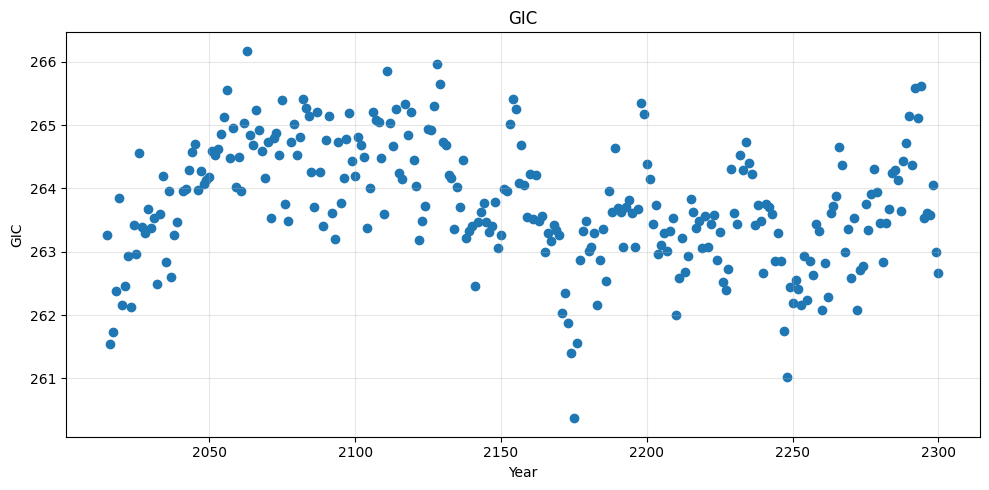

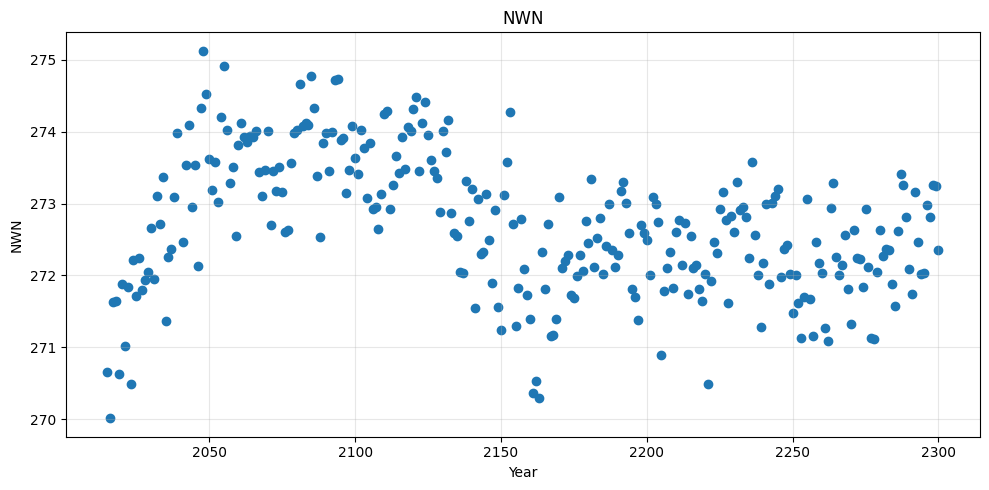

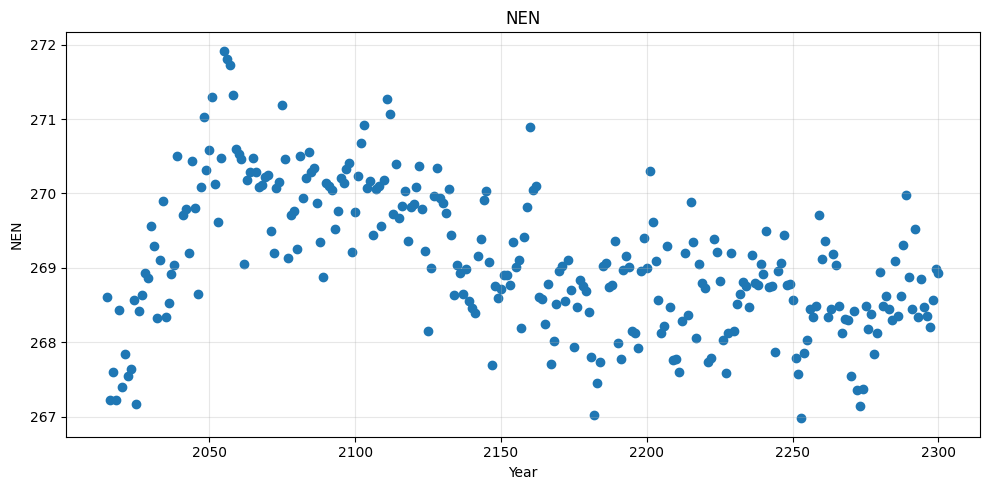

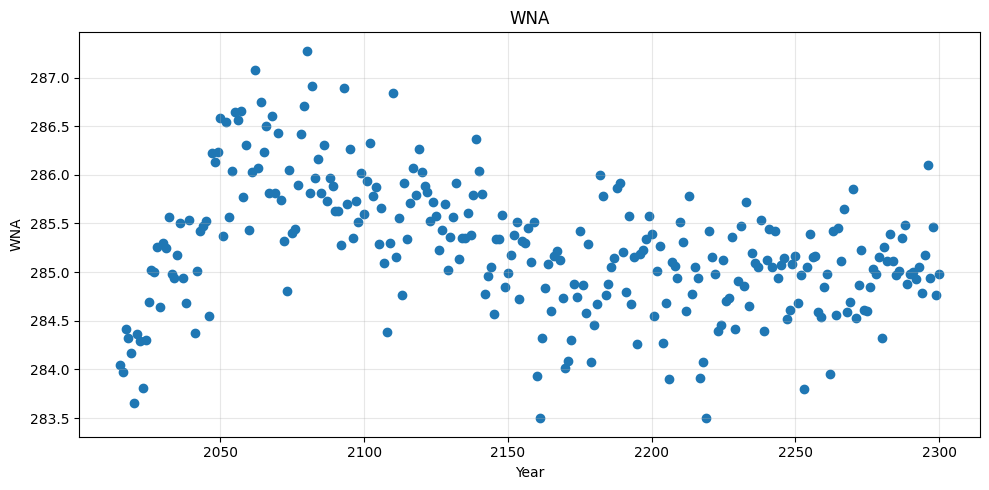

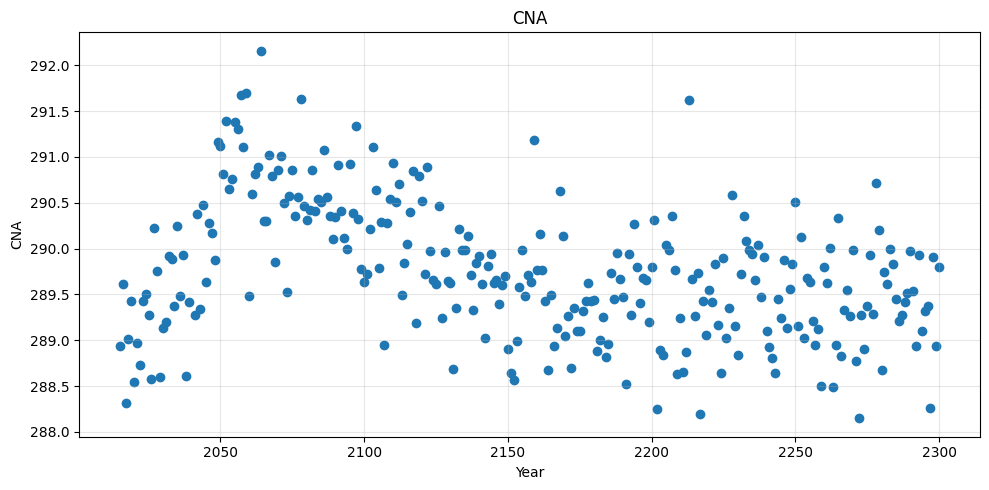

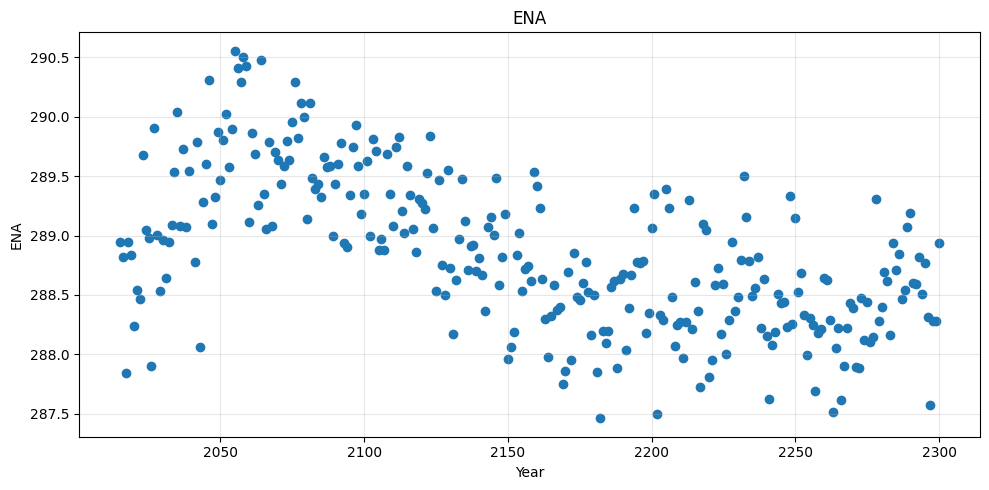

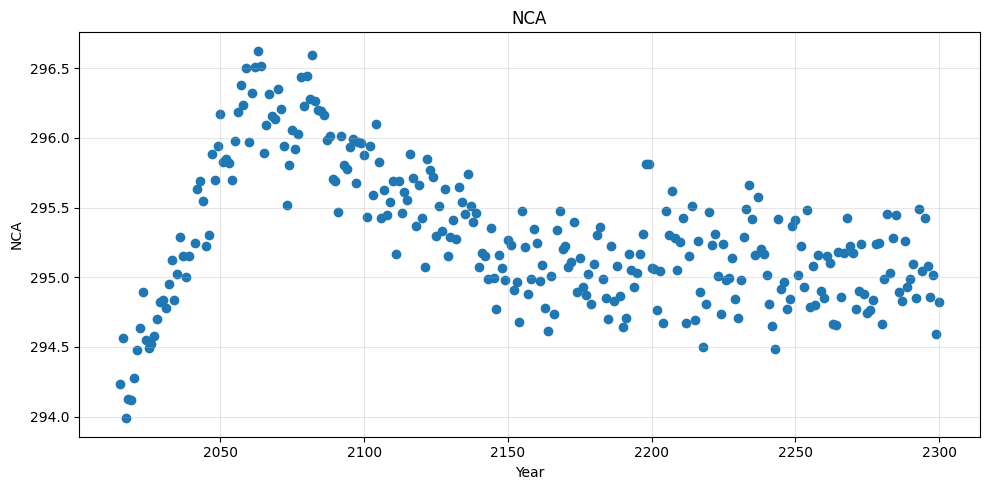

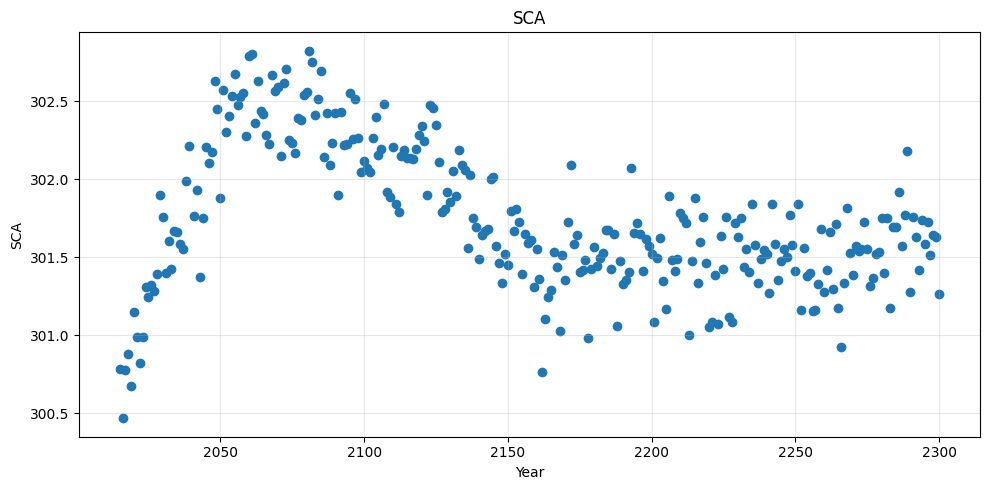

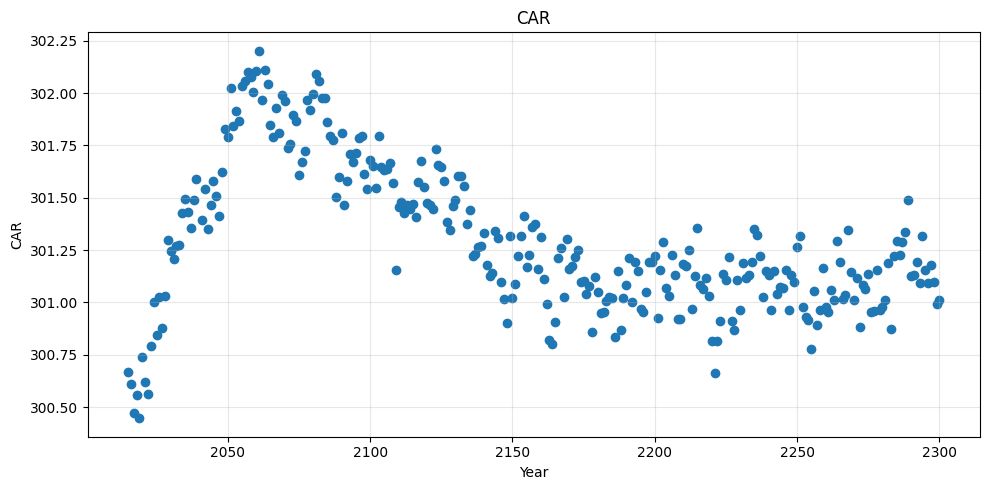

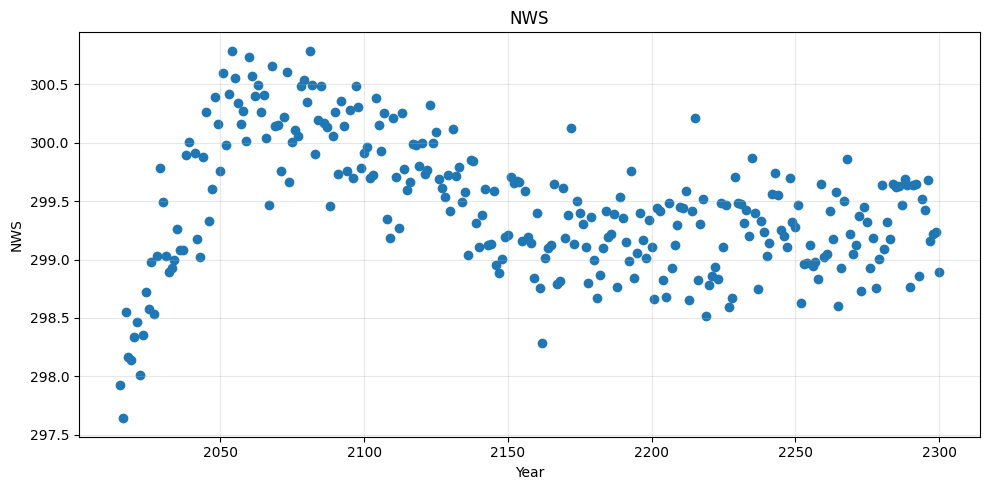

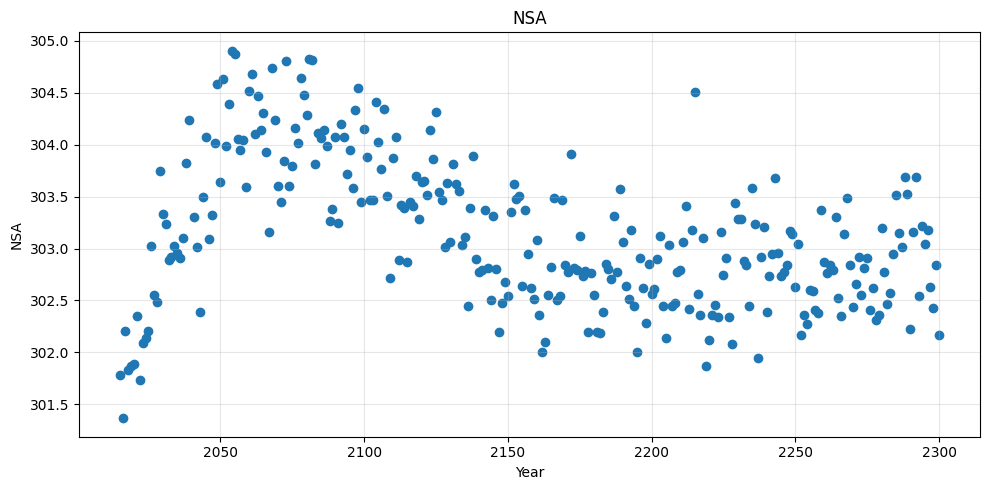

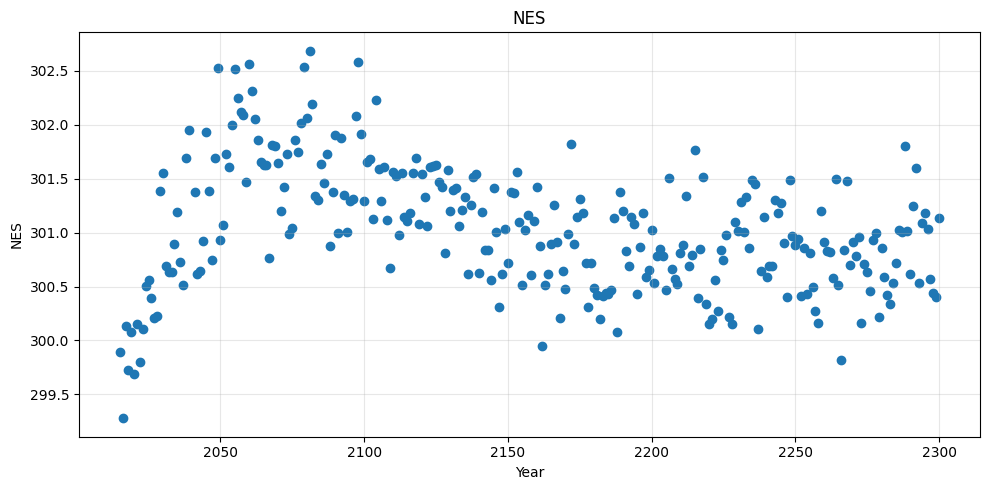

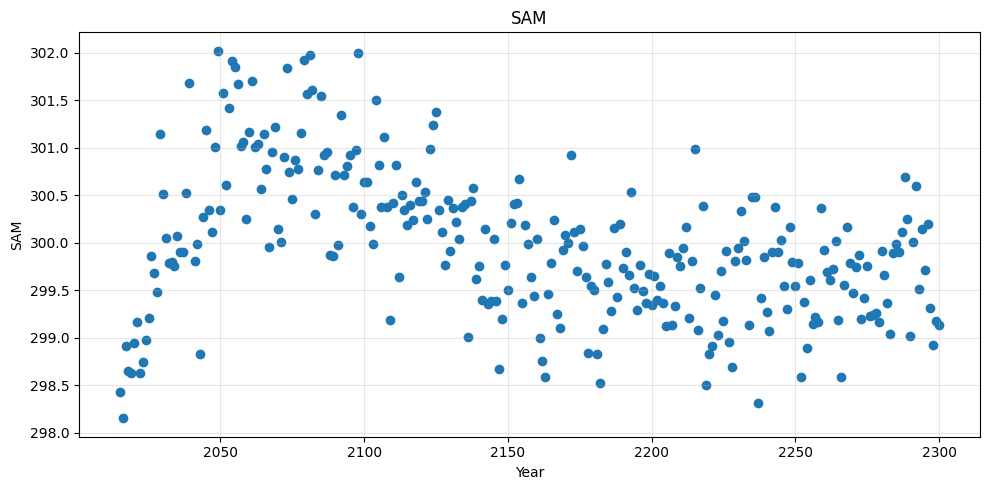

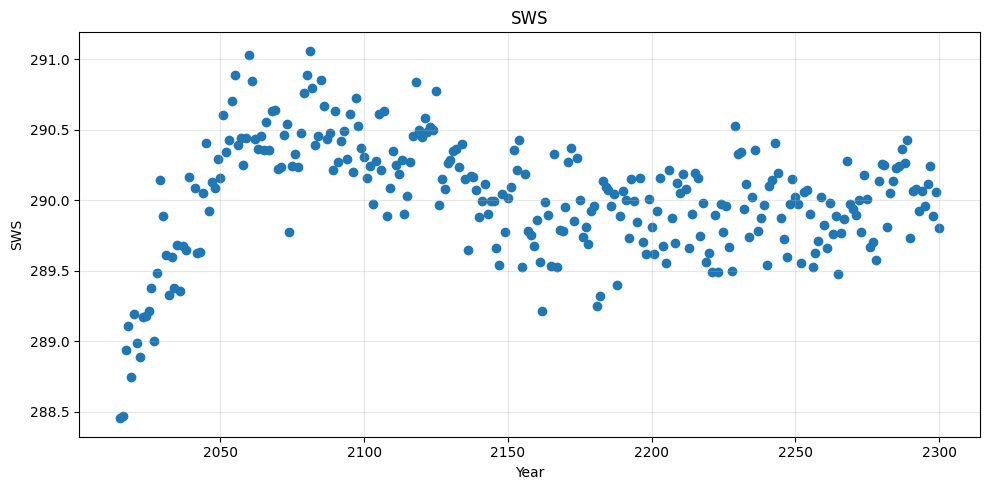

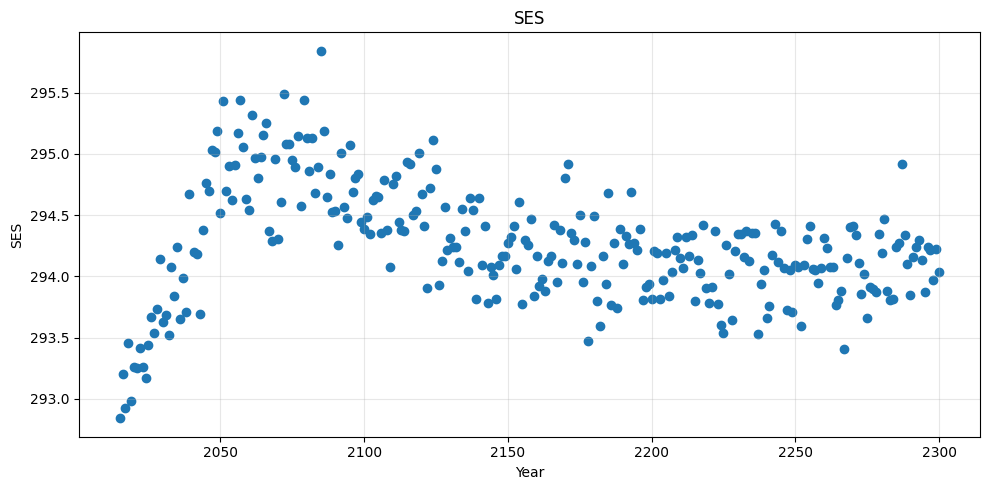

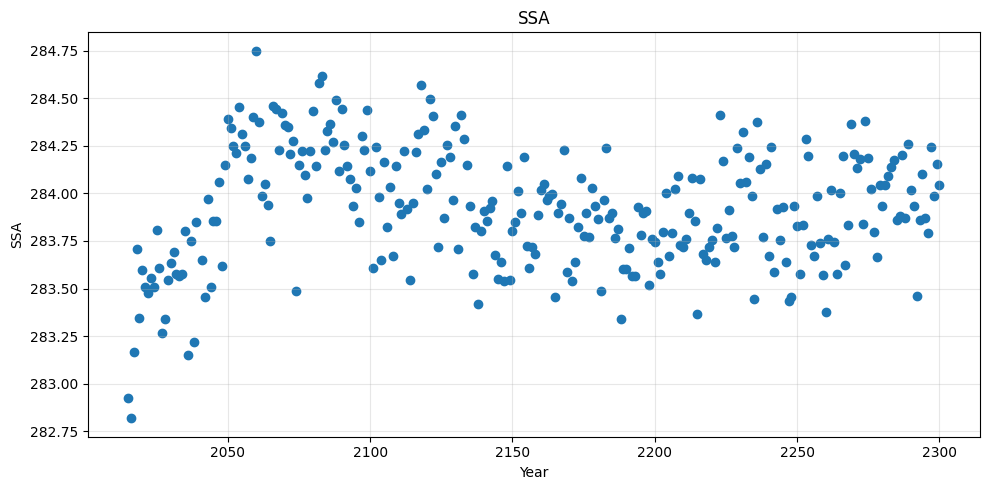

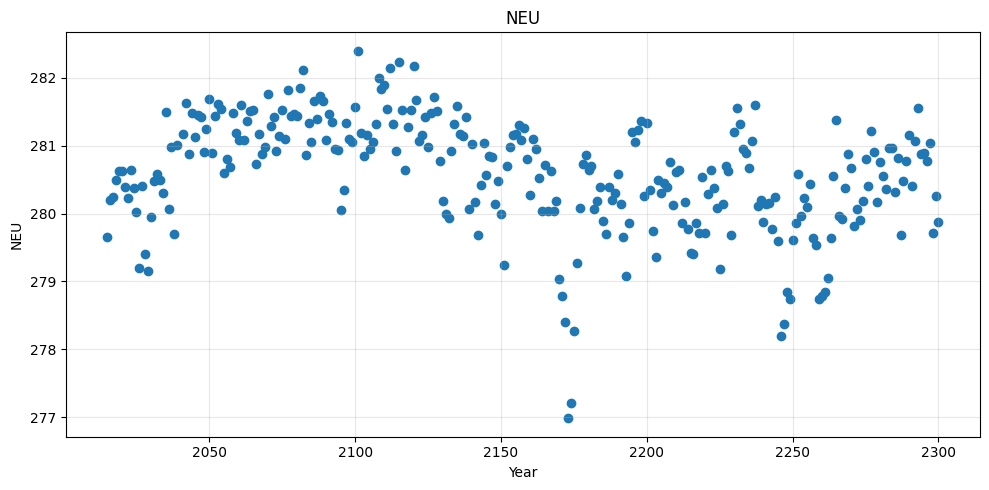

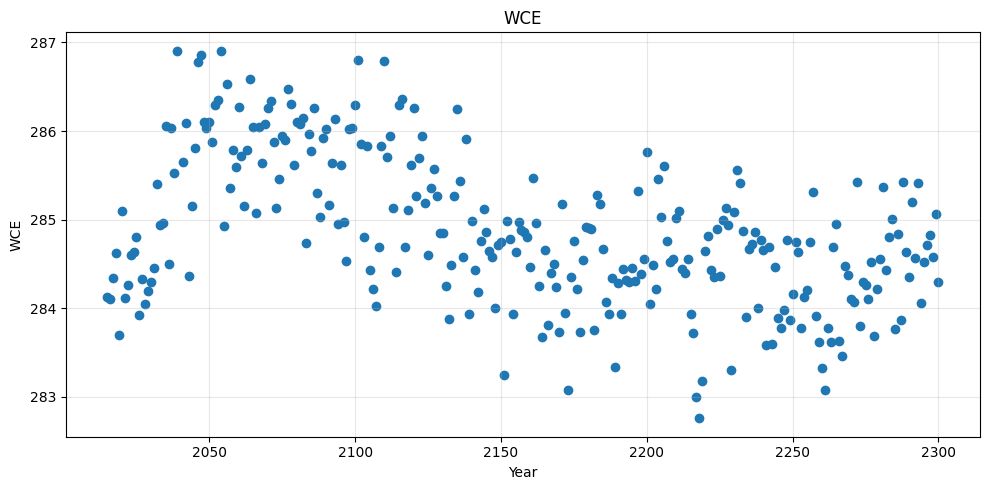

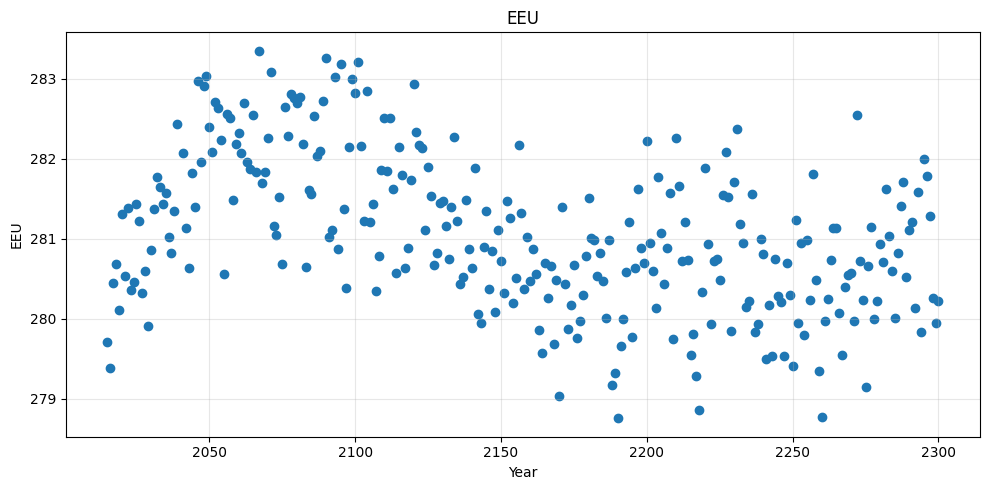

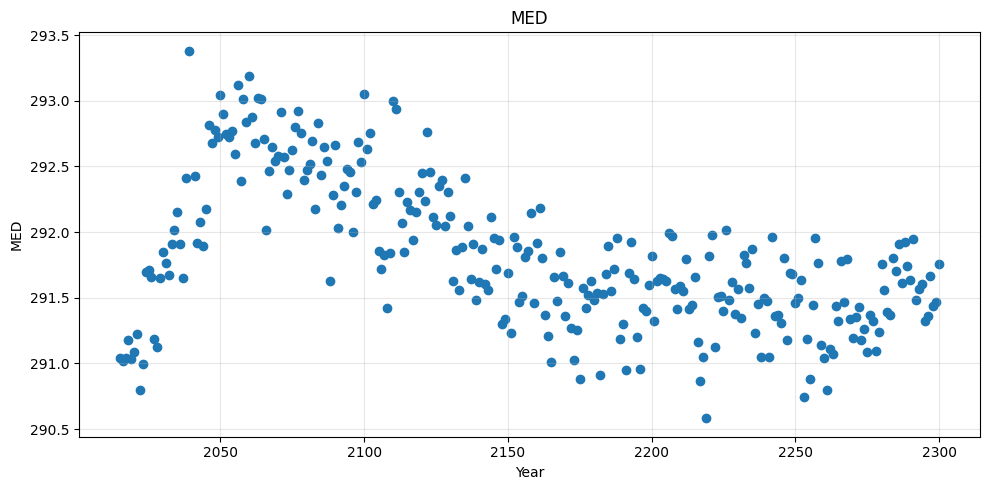

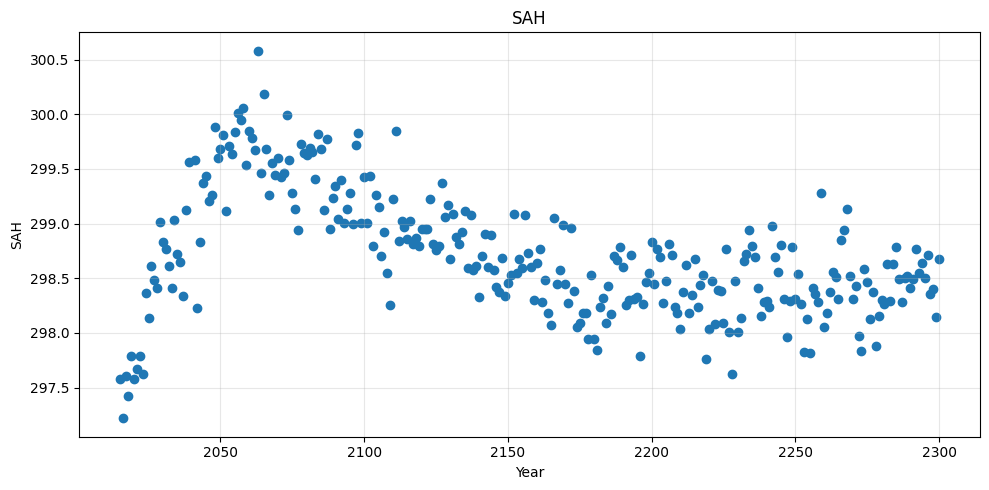

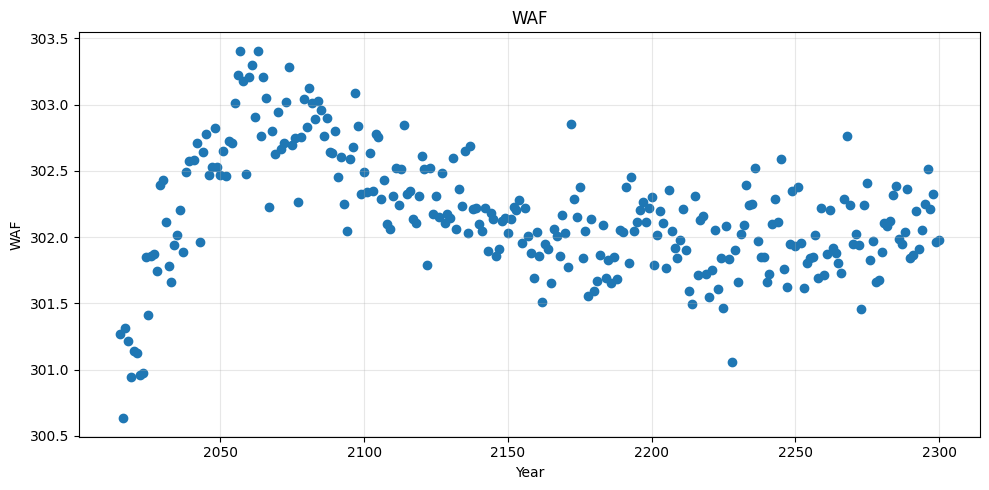

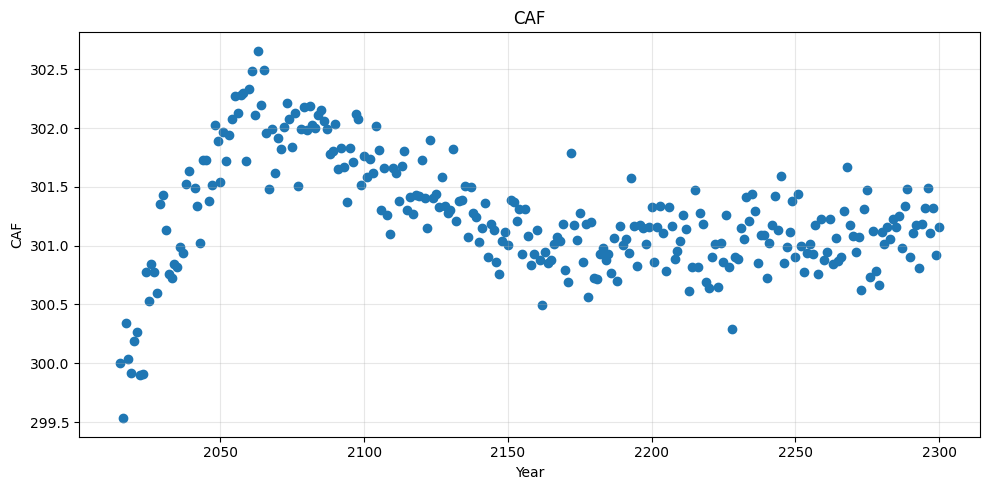

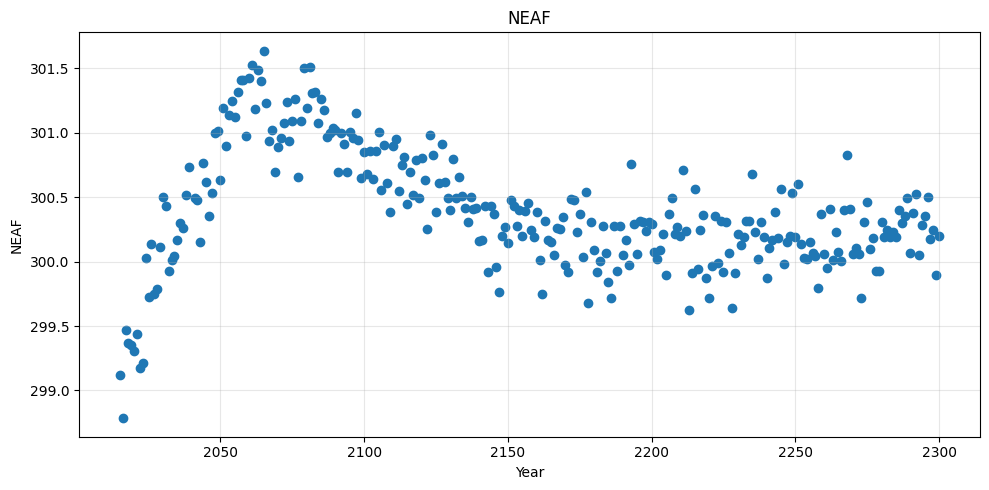

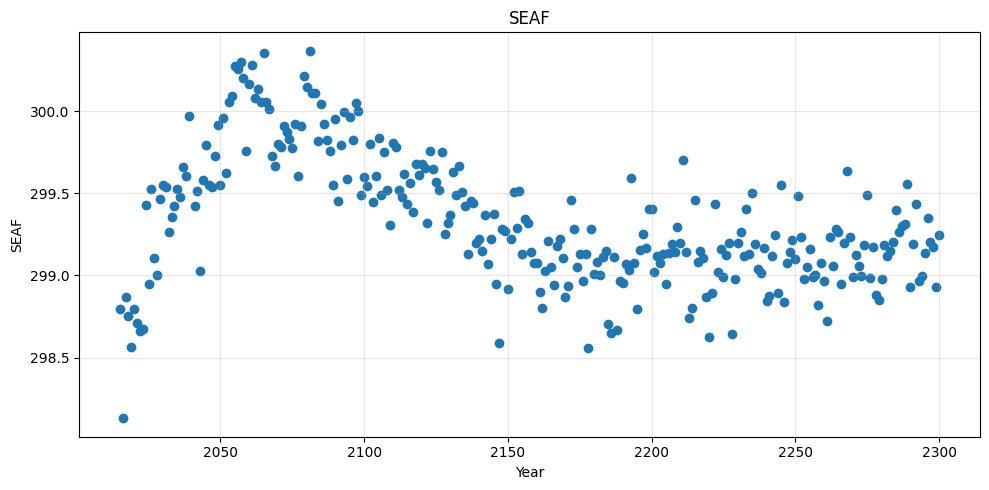

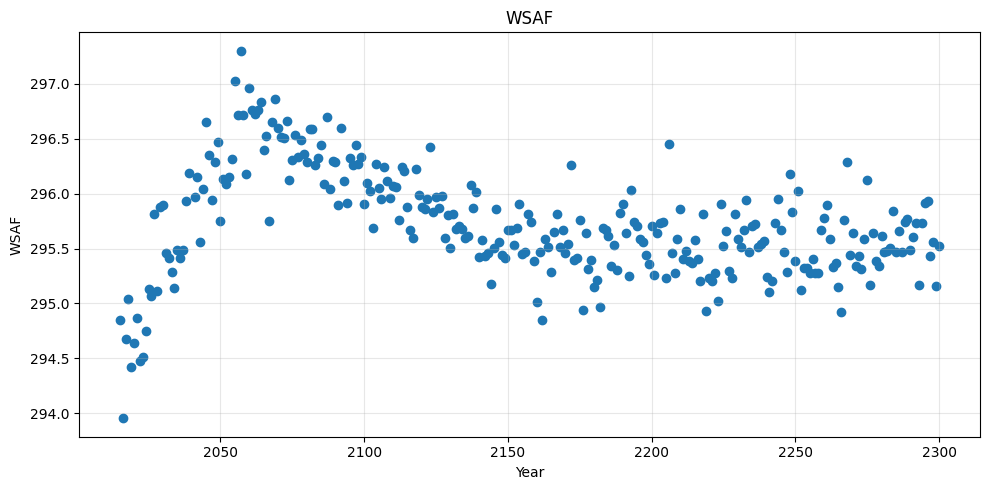

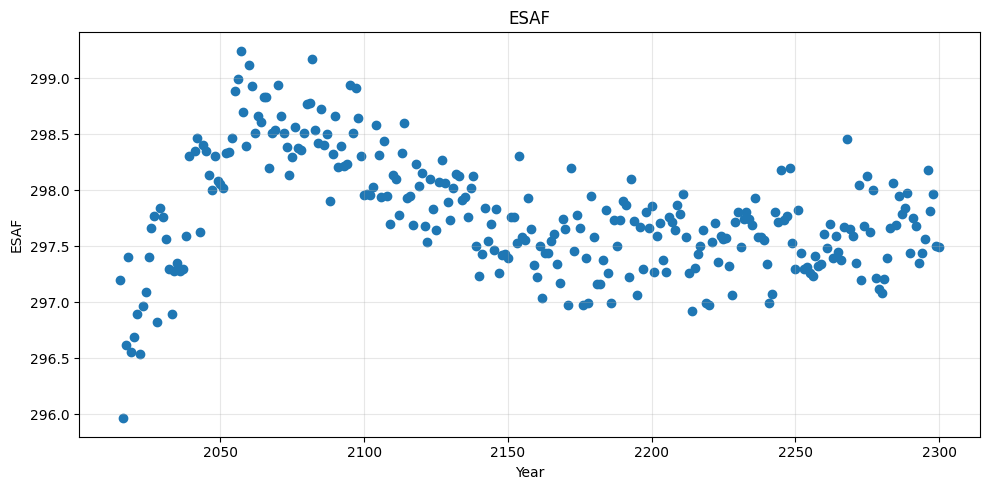

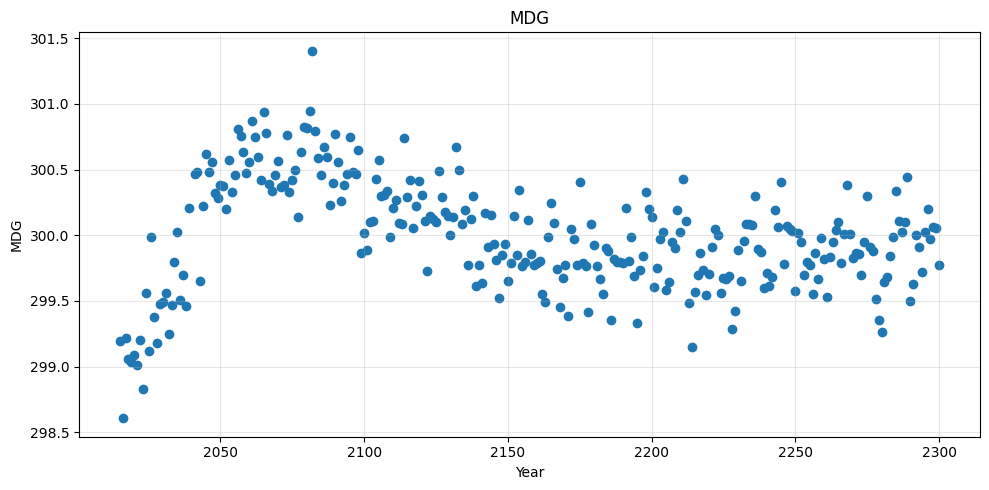

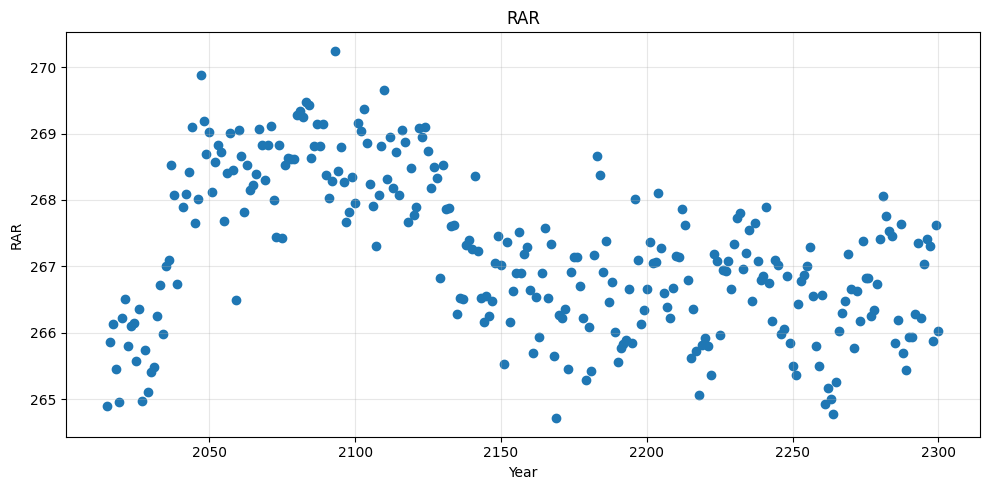

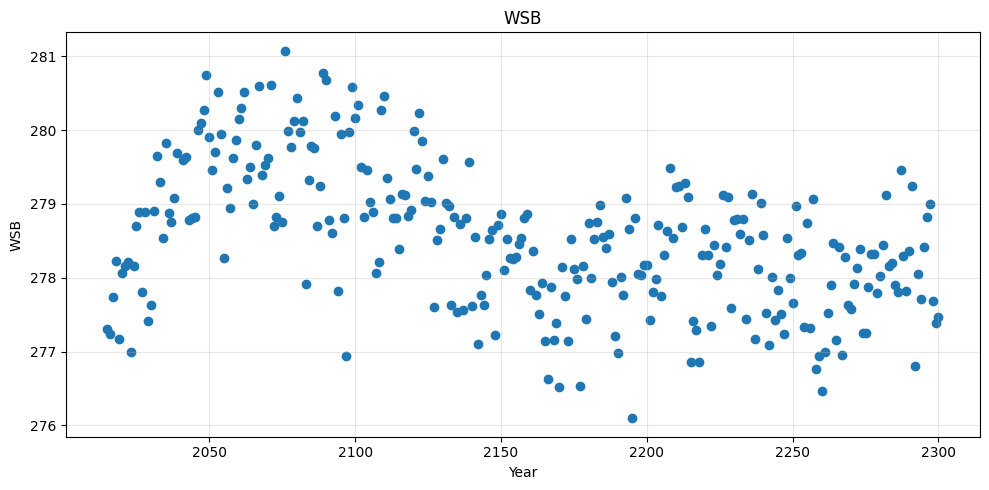

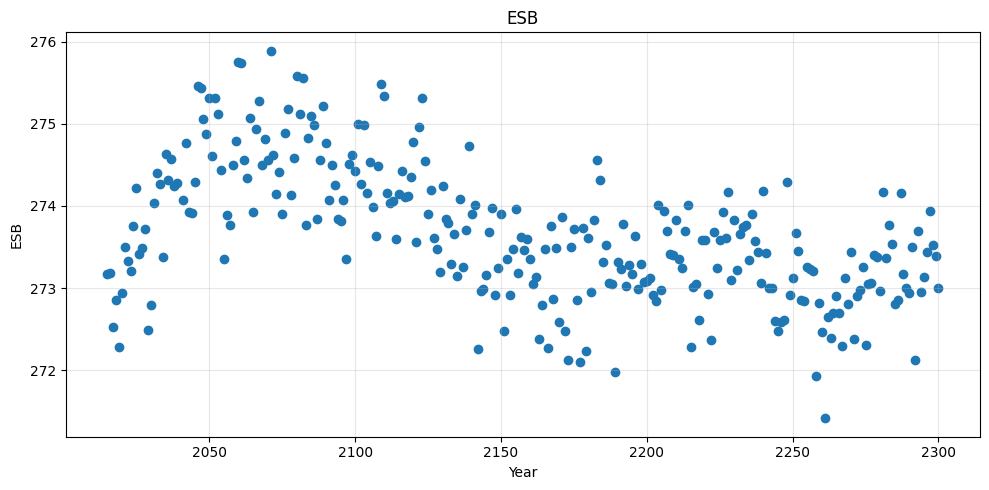

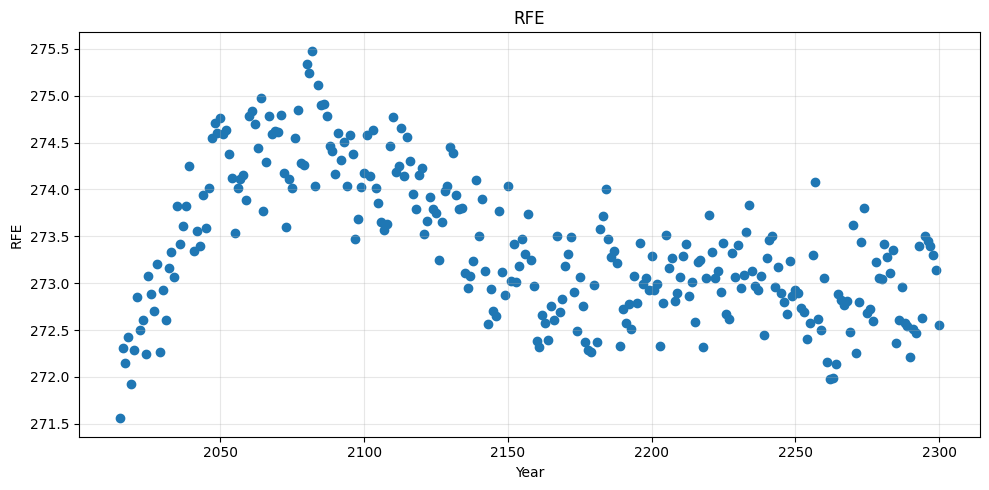

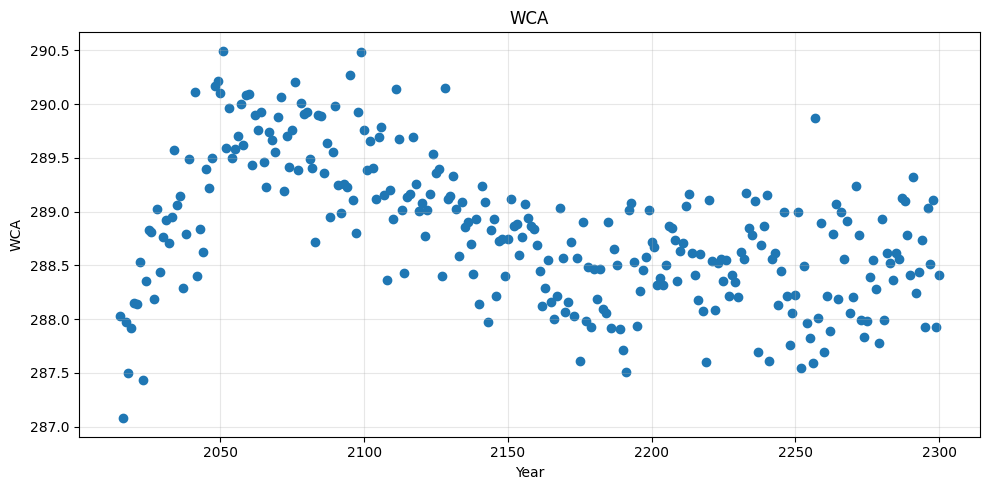

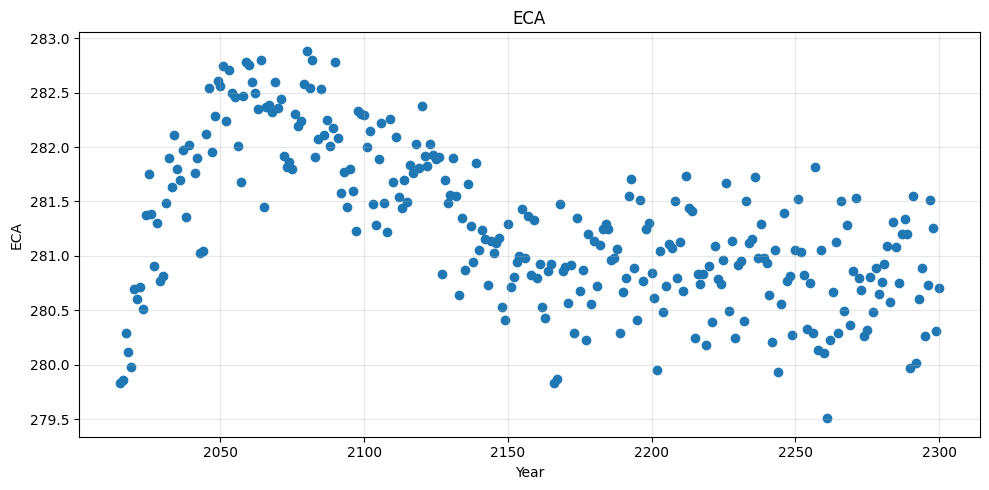

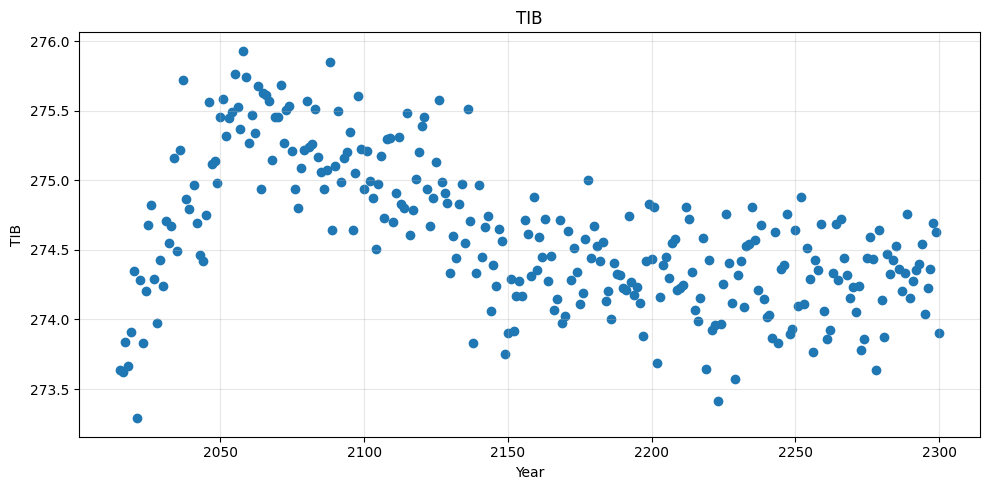

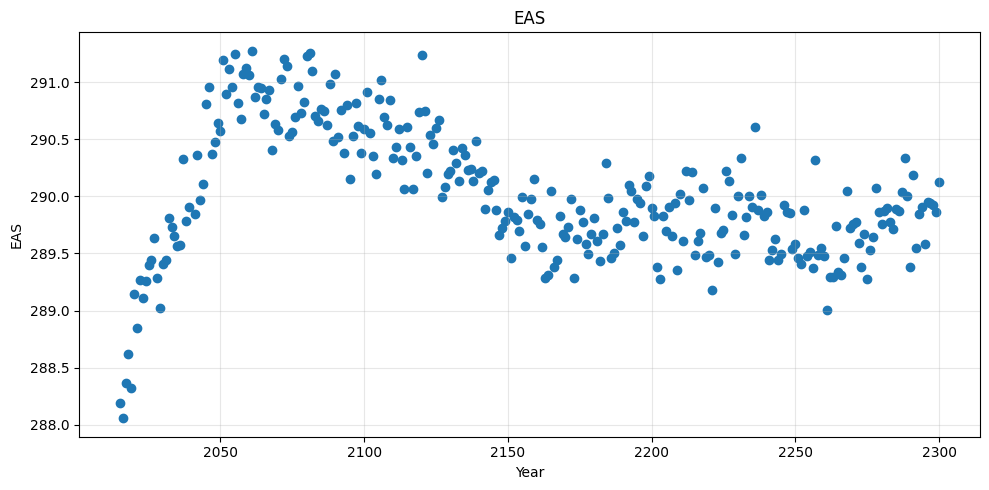

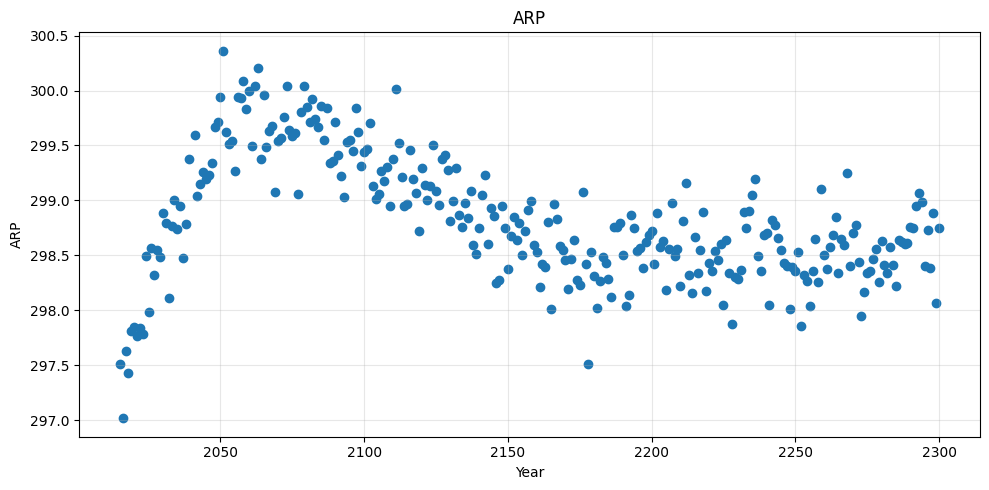

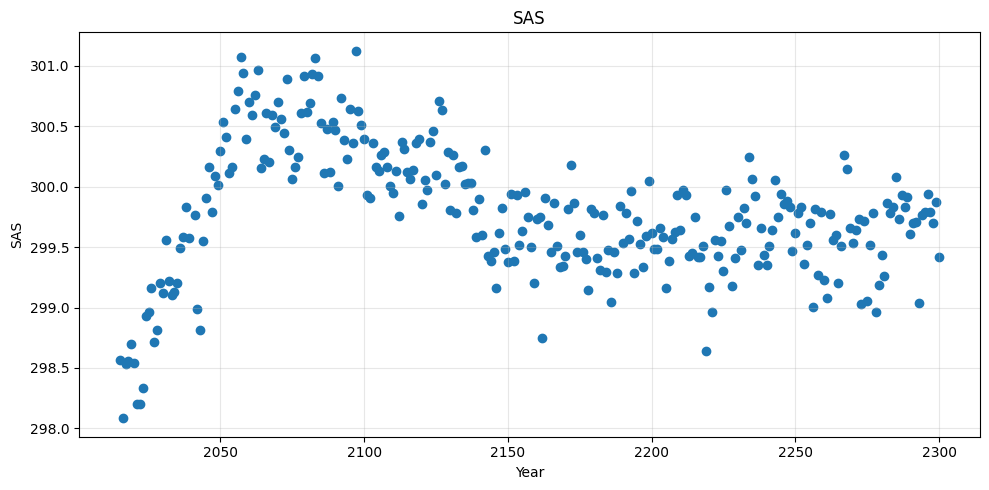

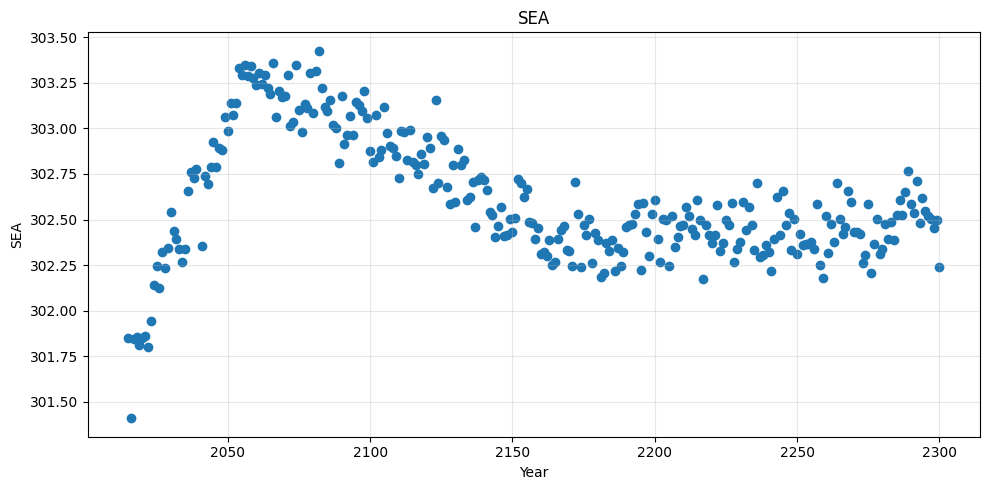

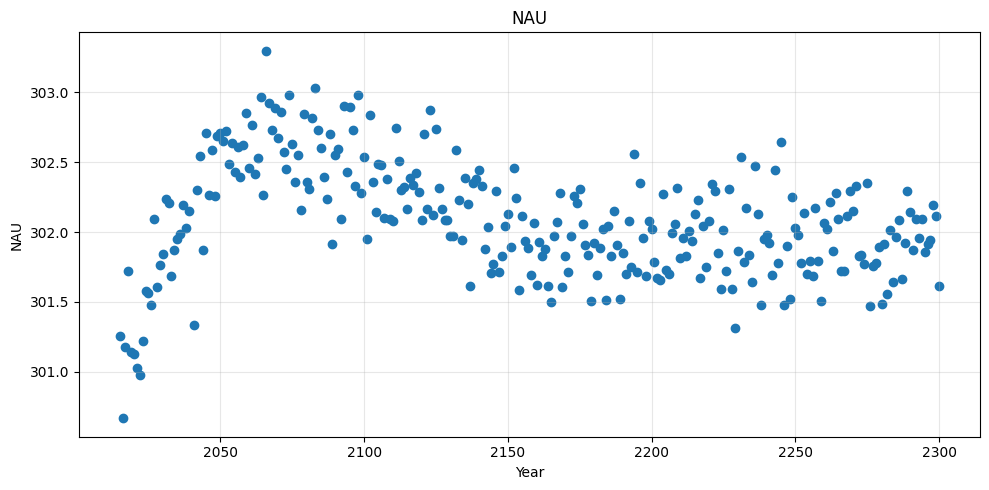

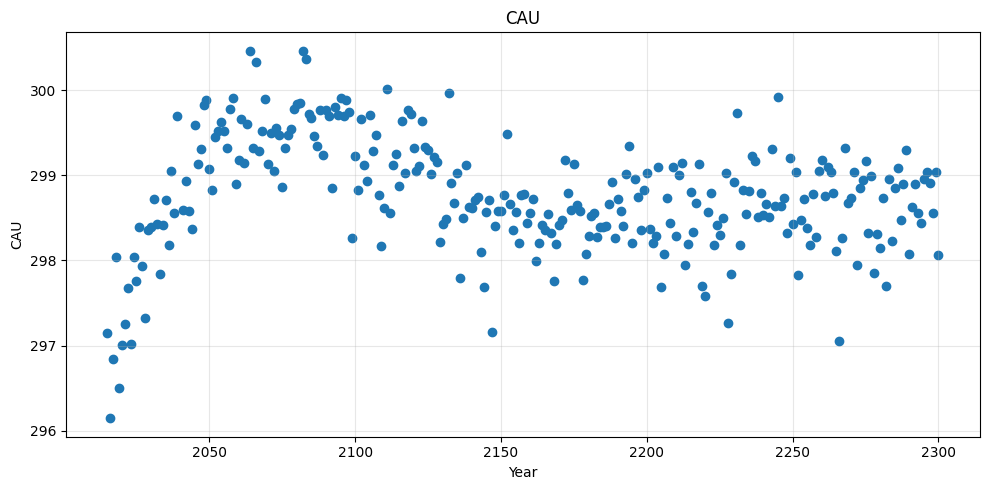

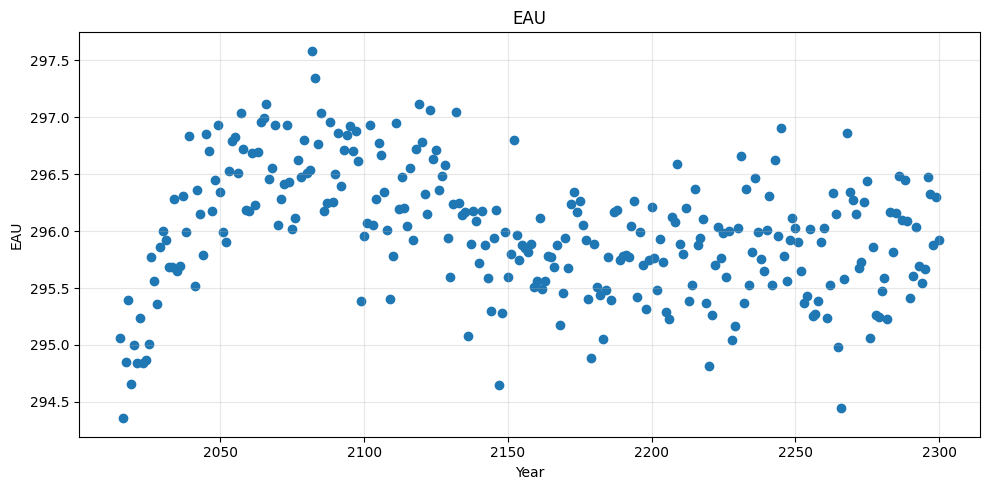

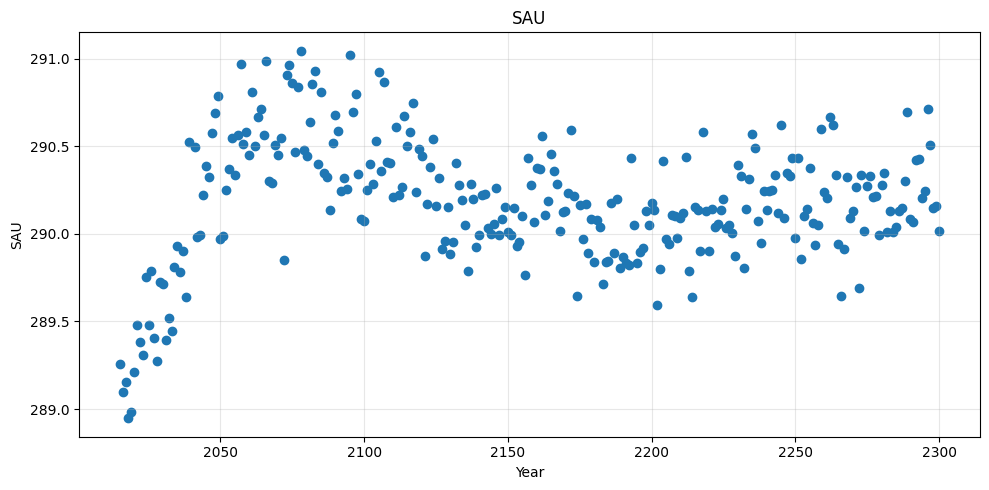

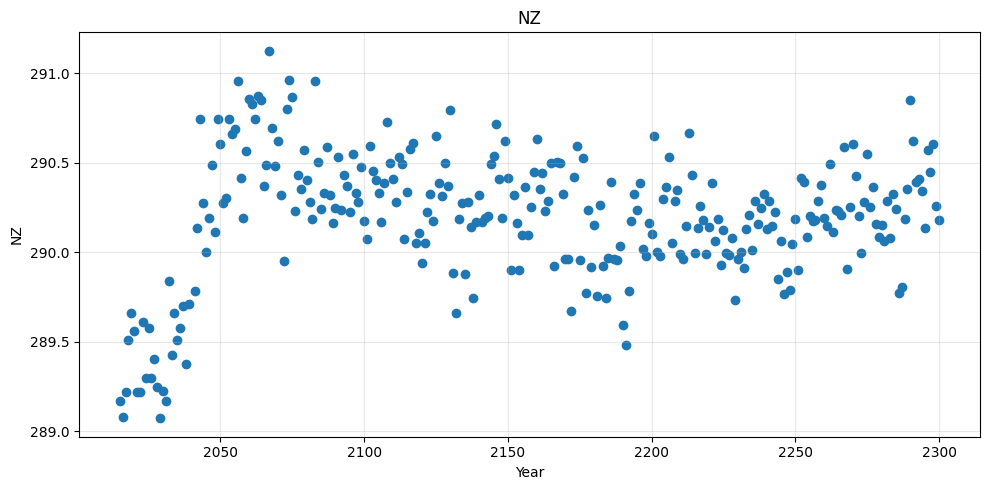

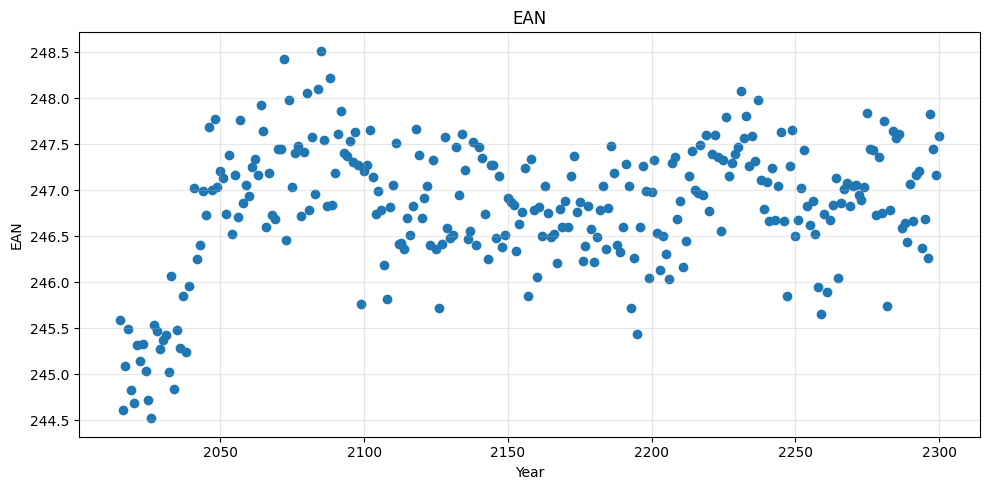

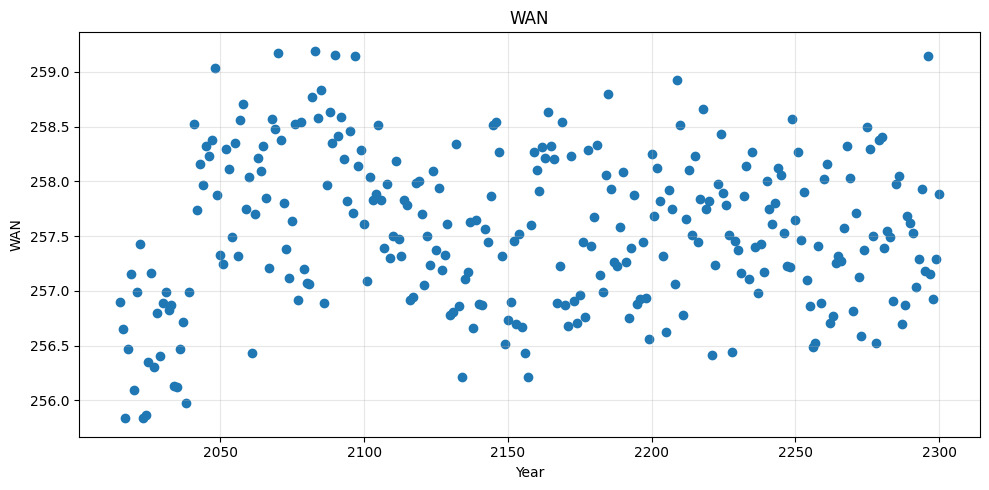

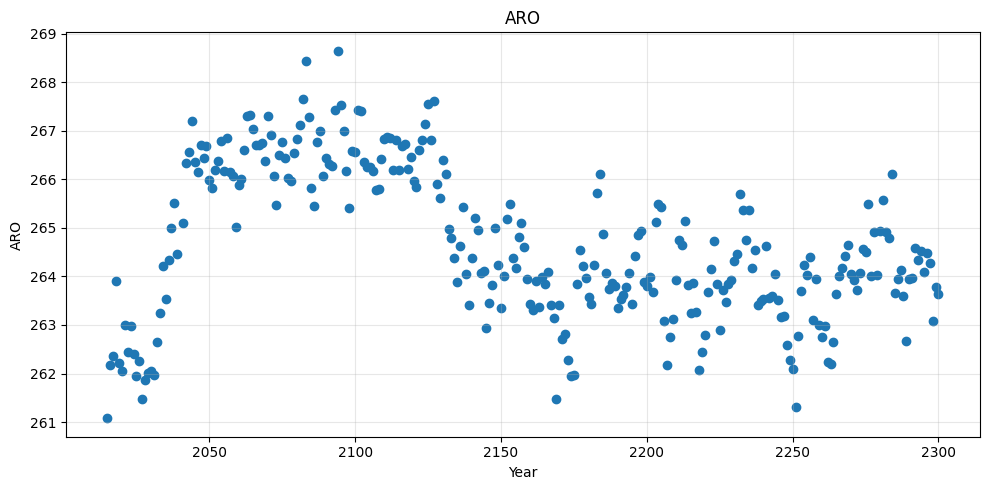

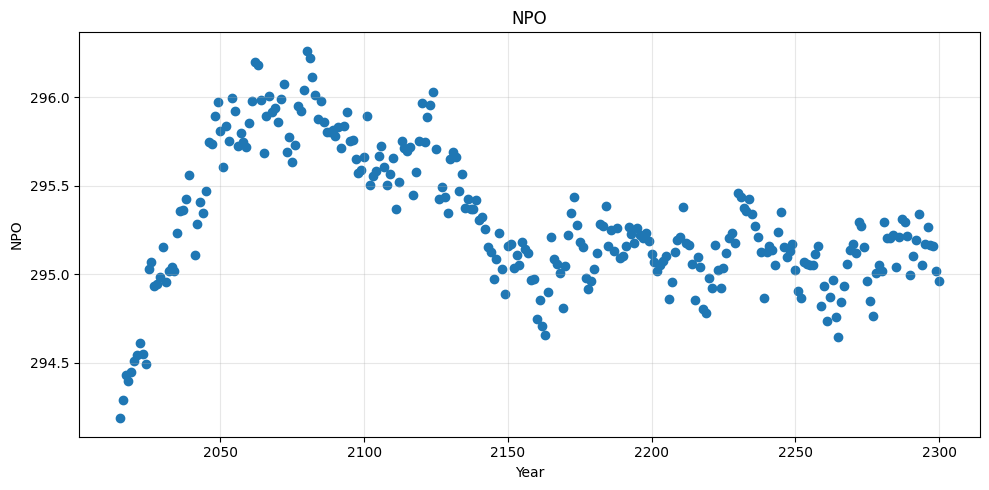

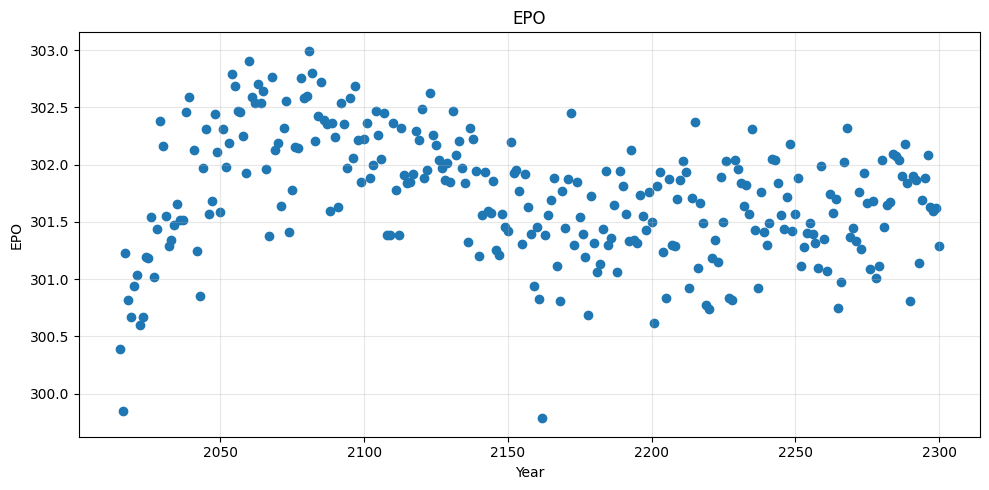

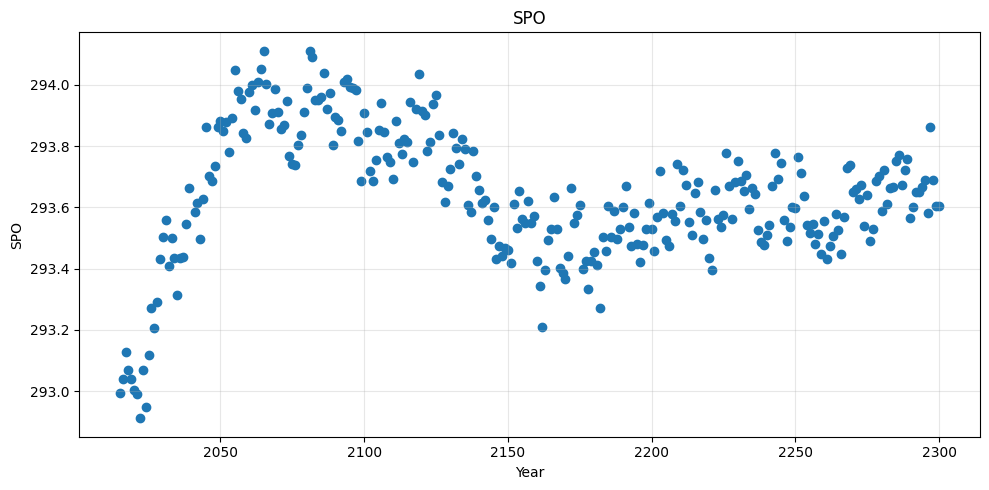

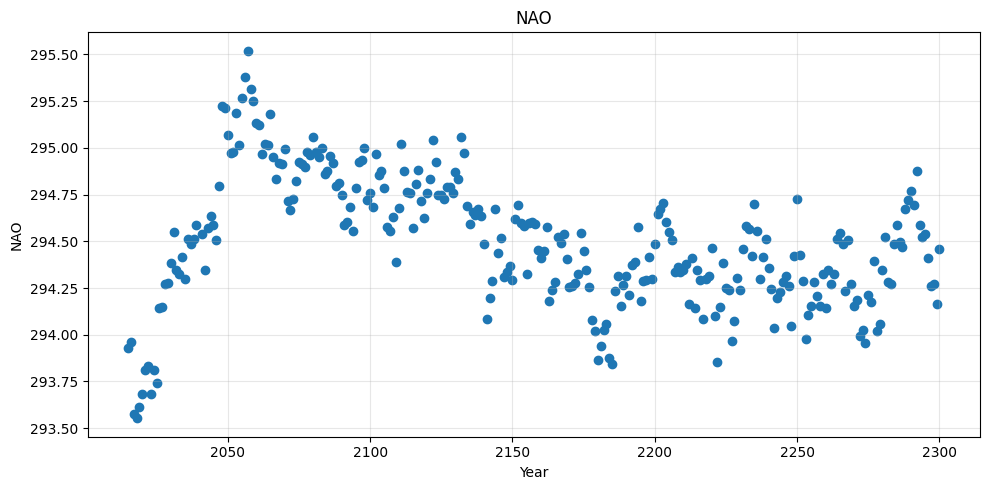

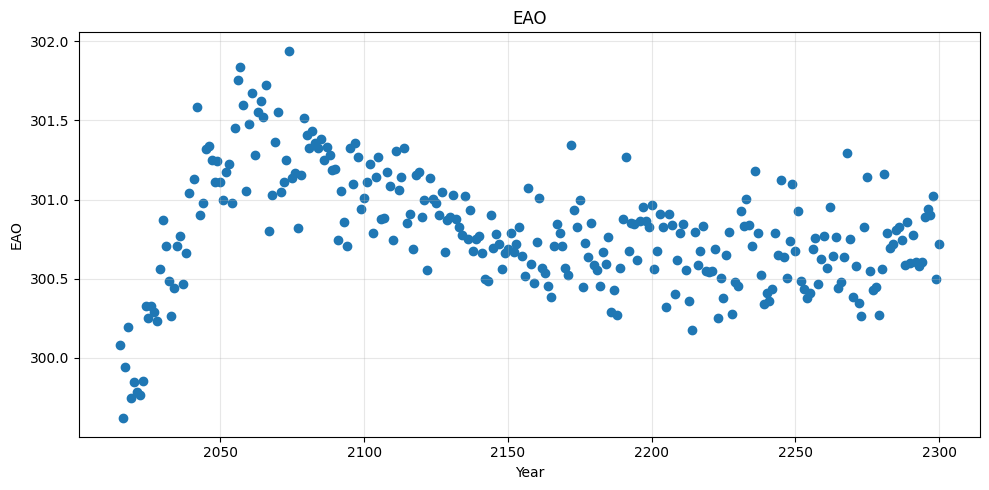

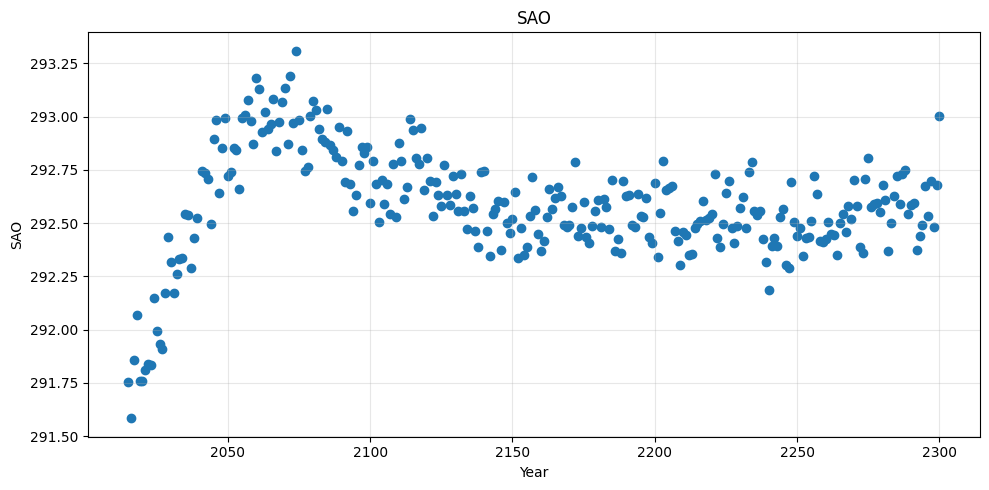

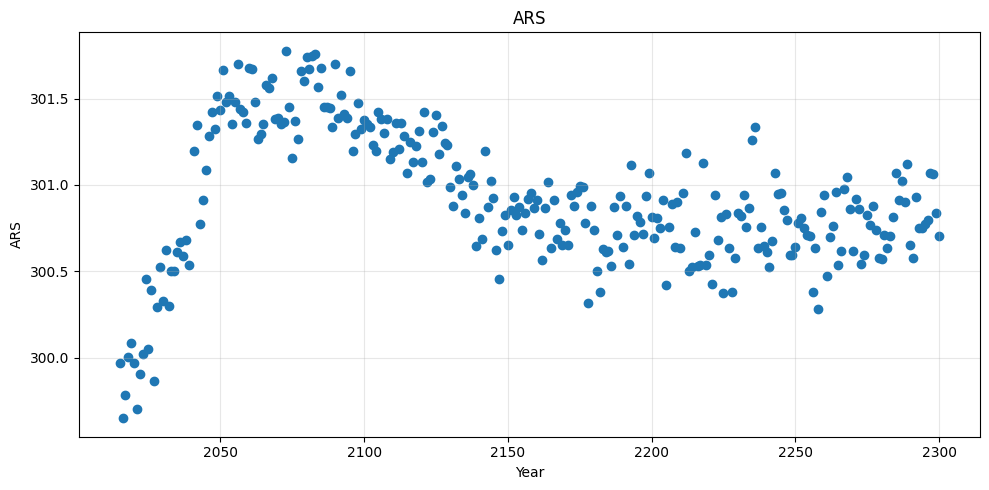

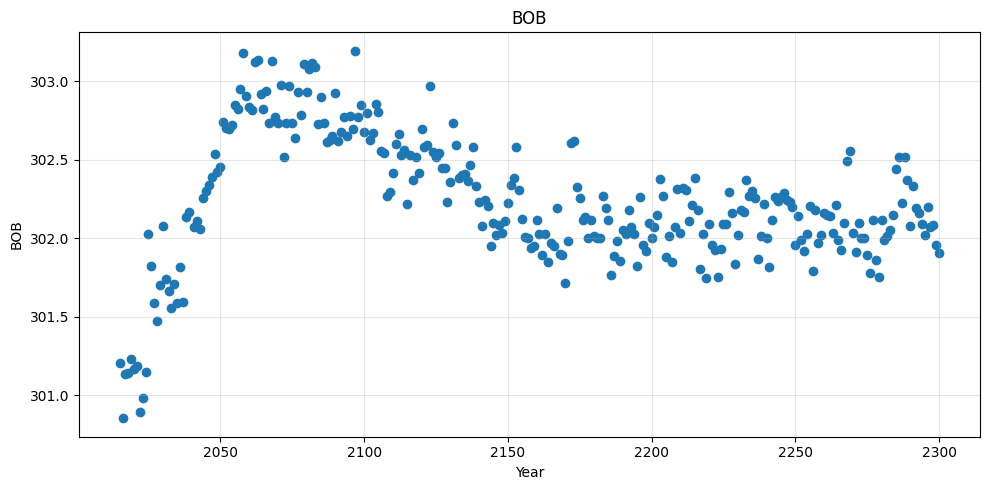

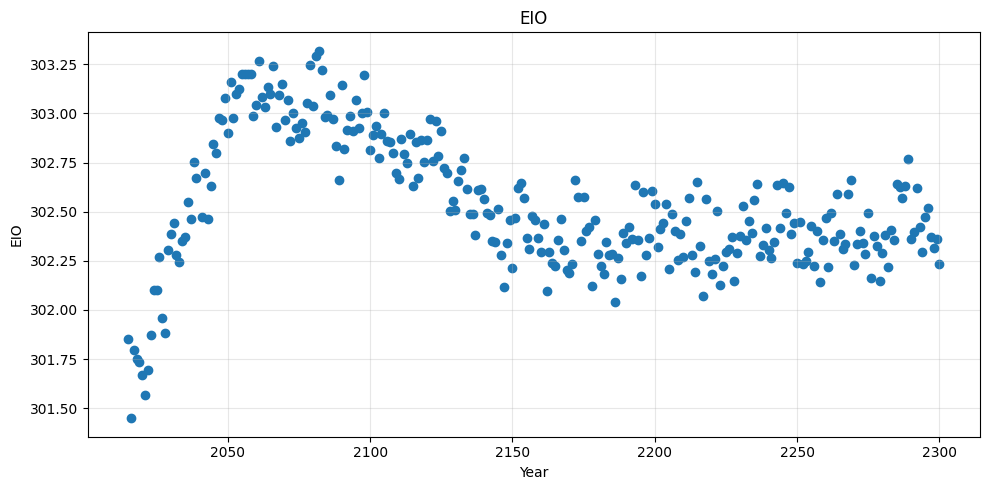

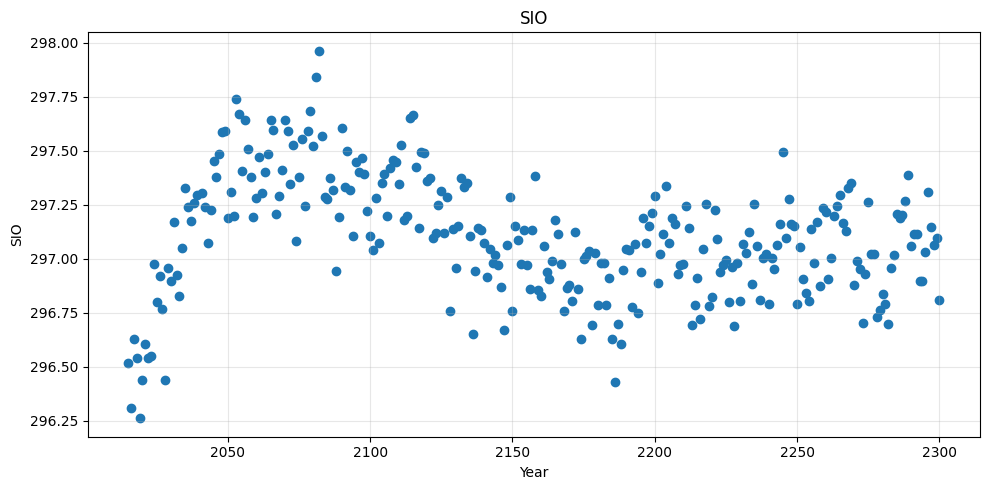

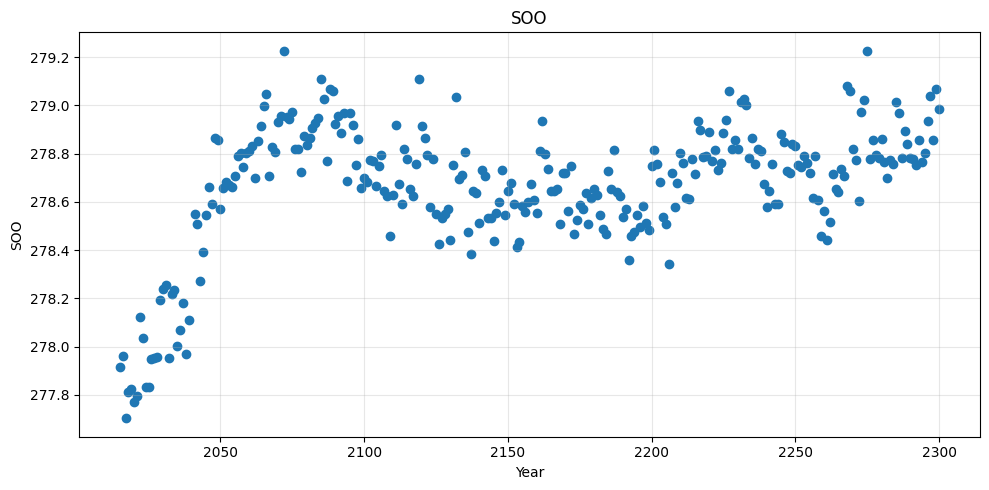

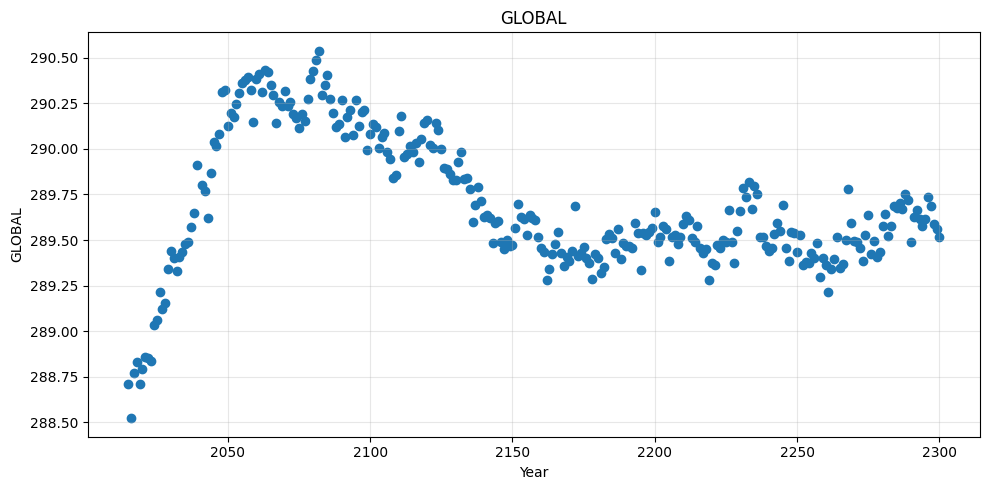

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

sim = '/mnt/PROVIDE/SCALES/cmip6-ng-inc-oceans/ACCESS-ESM1-5/access-esm1-5_ssp534-over-r1i1p1f1_tas_ipcc-regions_latweight.csv'

print(sim == sim_new_path)

# Assuming masks["GLOBAL"] is 2D (lat x lon)
plt.figure(figsize=(12, 5))
plt.title("Global Area Weights Mask (cos(lat))")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

def plot_each_region_separately(data, figsize=(10, 5)):
    """
    Plot annual averages for each region in separate figures.
    Works for years > 2262 because it does NOT use datetime64.
    """

    # --- Load data if pathname was passed ---
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data.copy()

    # --- Extract year as integer (safe for ANY year) ---
    df["year"] = df["time"].str[:4].astype(int)

    # Detect numeric columns (regions)
    regions = [col for col in df.columns if col not in ["time", "year"]]

    # --- Compute annual means ---
    df_annual = df.groupby("year")[regions].mean()
    #df_annual = df[regions]

    # --- Plot one figure per region ---
    for region in regions:
        plt.figure(figsize=figsize)
        plt.scatter(df_annual.index, df_annual[region])
        plt.title(region)
        plt.xlabel("Year")
        plt.ylabel(region)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_each_region_separately(sim)